In [41]:
!pip install pandas

In [42]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
base_dir = '/content/drive/MyDrive/MP1B/cnn'
!ls "/content/drive/MyDrive/MP1B/cnn"

bahan  latih  validasi


Menentukan Direktori

In [44]:
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir,'validasi')

Isi Bahan Direktori

In [45]:
Apel_dir = os.path.join(bahan_dir, 'Apel/')
Jeruk_dir = os.path.join(bahan_dir, 'Jeruk/')

print("Jumlah Data Train Tiap Kelas")
print('Jumlah gambar Apel :', len(os.listdir(Apel_dir)))
print('Jumlah gambar Jeruk :', len(os.listdir(Jeruk_dir)))

Jumlah Data Train Tiap Kelas
Jumlah gambar Apel : 50
Jumlah gambar Jeruk : 50


Direktori isi latihan dan Validasi

In [46]:
train_Apel = os.path.join(train_dir, 'Apel/')
train_Jeruk = os.path.join(train_dir, 'Jeruk/')

validation_Apel = os.path.join(validation_dir, 'Apel/')
validation_Jeruk = os.path.join(validation_dir, 'Jeruk/')

Menyiapkan DataSet

In [47]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio * total_size)
  val_size = total_size -train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  for i in train_files:
    i_file = source + i
    destination = train +i
    copyfile(i_file, destination)

    for i in val_files:
      i_file = source + i
      destination = val + i
      copyfile(i_file, destination)


train_ratio = 0.9


train_val_split(Apel_dir, train_Apel, validation_Apel, train_ratio)

source_00 = Apel_dir
train_00 = train_Apel
val_00 = validation_Apel
train_val_split(source_00, train_00, val_00, train_ratio)


source_01 = Jeruk_dir
train_01 = train_Jeruk
val_01 = validation_Jeruk
train_val_split(source_01, train_01, val_01, train_ratio)

In [48]:
print('Jumlah All Apel   :', len(os.listdir(Apel_dir)))
print('Jumlah Train Apel :', len(os.listdir(train_Apel)))
print('Jumlah Val Apel   :', len(os.listdir(validation_Apel)))

Jumlah All Apel   : 50
Jumlah Train Apel : 50
Jumlah Val Apel   : 25


Pre Processing

In [49]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range = 30,
                horizontal_flip = True,
                shear_range = 0.3,
                fill_mode = 'nearest',
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
              rescale = 1./255,
              rotation_range = 30,
              horizontal_flip = True,
              shear_range = 0.3,
              fill_mode = 'nearest',
              width_shift_range = 0.2,
              height_shift_range = 0.2,
              zoom_range = 0.1
)

target

In [51]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 100 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [52]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

Model CNN

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200, activation = 'relu'),
    tf.keras.layers.Dropout(0.3,seed=112),
    tf.keras.layers.Dense(500, activation = 'relu'),
    tf.keras.layers.Dropout(0.5,seed=112),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

In [54]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 200)                 │       3,699,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 500)                 │         100,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,824,486 (14.59 MB)

 Trainable params: 3,824,486 (14.59 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy']) # Changed 'accturacy' to 'accuracy'

In [56]:
history = model.fit(
            train_generator,
            steps_per_epoch = 9,
            epochs = 25,
            validation_data = val_generator,
            validation_steps = 1,
            verbose = 1,
            callbacks = [callbacks]
)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - accuracy: 0.5803 - loss: 0.9455 - val_accuracy: 1.0000 - val_loss: 0.4795
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8000 - loss: 0.5426 - val_accuracy: 0.9000 - val_loss: 0.3727
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9535 - loss: 0.3312 - val_accuracy: 1.0000 - val_loss: 0.0297
Epoch 4/25
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 1.0000 - loss: 0.0571
Akurasi mencapai 99%
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0571 - val_accuracy: 1.0000 - val_loss: 0.0131


Tingkat akurasi dan loss model

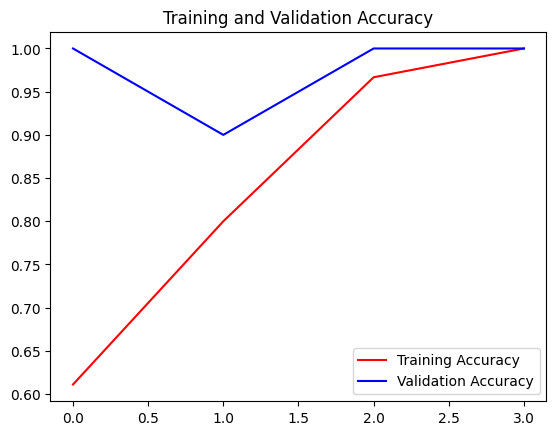

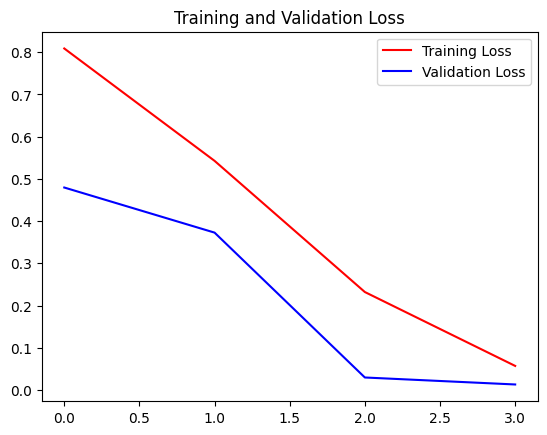

In [57]:
%matplotlib inline

import matplotlib.image as mping
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
vall_loss = history.history['val_loss']


epochs = range(len(val_acc))

plt.plot(epochs, acc[:len(val_acc)], 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.show()


plt.plot(epochs, loss[:len(vall_loss)], 'r', label='Training Loss')
plt.plot(epochs, vall_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.show()

Mencoba Klasifikasi

Saving gettyimages-1182452536-612x612_jpg.rf.8cb13017fa488ab575f2b94728d6976f.jpg to gettyimages-1182452536-612x612_jpg.rf.8cb13017fa488ab575f2b94728d6976f.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
gettyimages-1182452536-612x612_jpg.rf.8cb13017fa488ab575f2b94728d6976f.jpg
This image belongs to class Jeruk


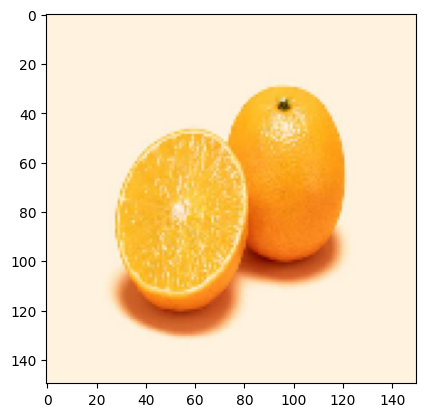

In [59]:
import numpy as np
from keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size = (150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)

  class_list = os.listdir(train_dir)

  for j in range(42):
    if classes[0][j] --1. :
      print('This image belongs to class', class_list[j-1])
      break